ANTSpy stands for "Advanced Normalization Tools in Python" 


their GitHub repo https://github.com/ANTsX/ANTsPy


ANTSpy docs https://antspy.readthedocs.io/en/latest/


to install run '''pip install antspyx'''

In [1]:
pwd

'/mmfs1/data/aglinska/BC-MISC-Tutorials/Python Basics'

In [2]:
import ants # Takes a while to import
import numpy as np
from matplotlib import pyplot as plt

/data/aglinska/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/data/aglinska/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/data/aglinska/anaconda3/lib/python3.8/site-packages/paramiko/transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In the ./Data/ directory there's a folder called 'sub-28702' with neuroaantomical data for one subject organized according to BIDS specification. 

BIDS, stands for "Brain Imaging Data Structure" https://bids.neuroimaging.io/ and is a commonly agreed upon way to store and organized MRI and fMRI files

In this tutorial we will see how to load, plot and manipulate these files

In [3]:
anat = ants.image_read('./Data/sub-28702/anat/sub-28702_desc-preproc_T1w.nii.gz') # reads the nifti file into ants object
anat # Printing the ants object shows header information
# you can acess the header values like this:
# anat.shape
# anat.spacing
# anat.origin

ANTsImage (LPI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (220, 320, 208)
	 Spacing    : (0.8, 0.8, 0.8)
	 Origin     : (88.9204, 128.4992, -65.1701)
	 Direction  : [-1.  0.  0.  0. -1.  0.  0.  0.  1.]

### Plotting brains

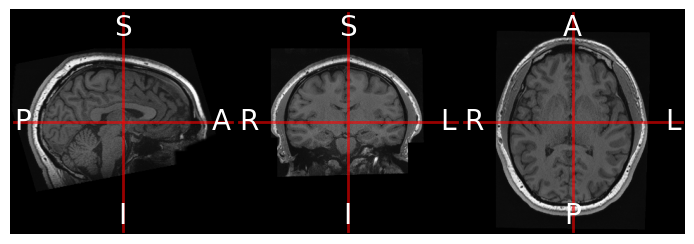

In [4]:
anat.plot_ortho(flat=True) # Plots the 3D brain showing three slices: Axial, Coronal and Saggital

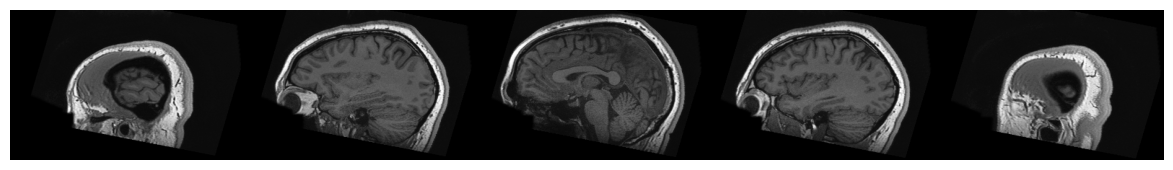

In [5]:
anat.plot(nslices=5) # This plots a specified number of slices from the same orientation (defaults: 5 slices from the first dimension, here: saggital)

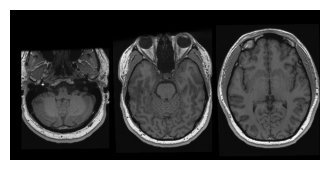

In [6]:
anat.plot(axis=2,slices=[50,75,100]) 
# Axis= controls how to plot the slices (usually 0=saggital, 1=coronal,2=axial)
# slices= takes in a list to plot slices at those indices, here plots slices 50,75,100. Make sure the slice index does not exceed the dimensions of the image (here 220, 320, 208)

## Acessing the numpy values 

In [7]:
# You can also visualize the image by acessing the numpy array specifying the values describing the image
anat_arr = anat.numpy() # 3D numpy array with voxel values. Has everything you need to do statistical tests, plotting etc. But does not have the associated metadata, i.e. header values that you would need to save a valid nifti image
print(type(anat_arr))
print(anat_arr.shape)

<class 'numpy.ndarray'>
(220, 320, 208)


In [8]:
manual_slice1 = anat_arr[110,:,:] # index thr brain like you would a numpy array

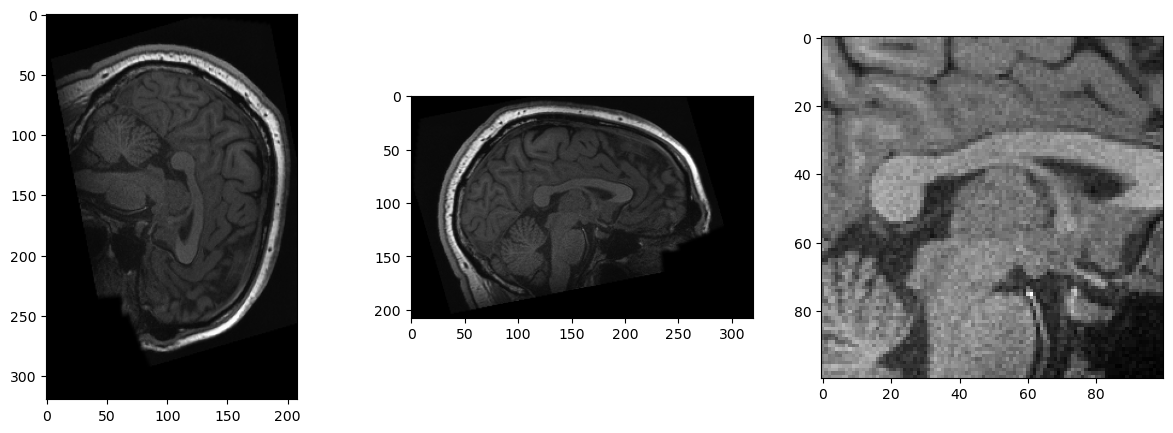

In [9]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1);plt.imshow(manual_slice1,cmap='gray') # Orientated weird because ANTS automatically orients images for you when plotting

manual_slice1_rotated = np.rot90(manual_slice1) # You can rotate the 2D slice manually 
plt.subplot(1,3,2);plt.imshow(manual_slice1_rotated,cmap='gray') # Orientated weird because ANTS automatically orients images when plotting

plt.subplot(1,3,3);
manual_slice1_rotated_cropped = manual_slice1_rotated[50:150,100:200] # You can play with indexing to zoom in to structures you want etc. Here let's crop in to the values in the middle
plt.imshow(manual_slice1_rotated_cropped,cmap='gray')

### Overlaying images

In [10]:
# Let's learn how to overlay one image on top of another. This is useful for things like:
# 1. Overlaying statistical results, like t-values on top of a brain image to see where in the brain effects are
# 2. Checking segmentation: Seeing if gray matter, white matter and cerebrospinal fluid in the brain was correctly identified by the preprocessing pipeline
# 3. Overlaying two different brains on top of one another to see if they're orientated the same way

In [11]:
# Let's load a brain mask from given by fMRIprep preprocessing pipeline
# This should have values of 1 for brain tissue, and 0 everywhere else
brain_mask = ants.image_read('./Data/sub-28702/anat/sub-28702_desc-brain_mask.nii.gz') # reads the nifti file into ants object

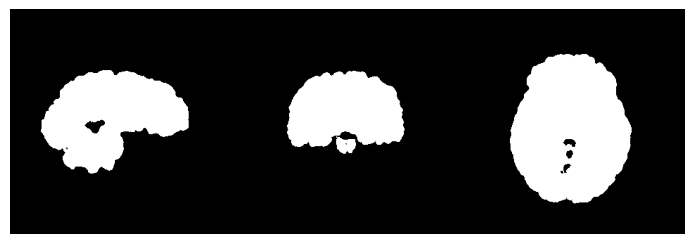

In [12]:
brain_mask.plot_ortho(flat=True,xyz_lines=False,orient_labels=False) # plot it

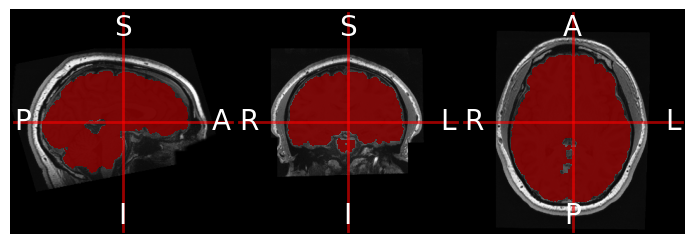

In [13]:
anat.plot_ortho(brain_mask,flat=True) # plot anat and pass in brain_mask as a parameter to overlay it

In [14]:
# It looks good, seems like the brain was identified correctly

### Manipulating images


Let's learn how to manipulate images. 

Specifically, let's extract just the brain tissue from the neuroanatomical scan


This is a commonly done preprocessing procedure, because we want to analyse brain tissue without the rest of the head getting in the way!


We have both things that we need for this: **anat** image that has both the brain brain and non brain (head & scull) and **brain_mask** image specifying where the brain is (but not the values for th signal intensity in the brain, just zeros and ones)


Let's use the anat and brain_mask images to zero out the values that is not brain tissue


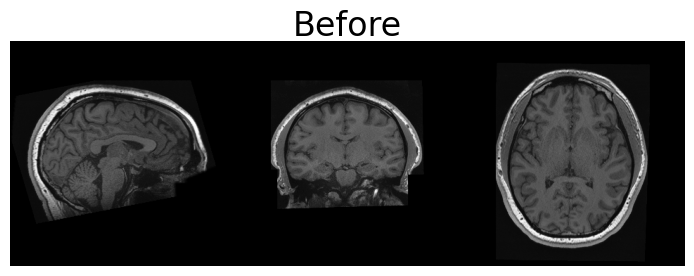

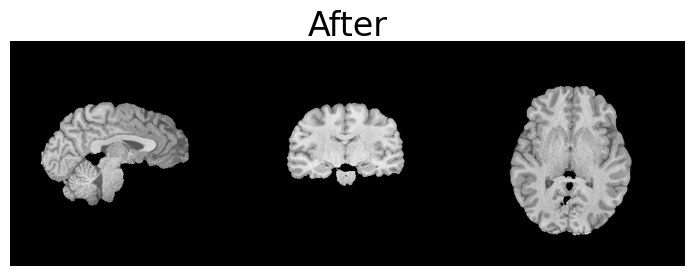

In [15]:
# FAST WAY
brain = anat.copy() # Make a copy of the anat, that we will change 
brain.plot_ortho(flat=True,title='Before',textfontcolor='k',xyz_lines=False,orient_labels=False) # Plot the image before 

brain[brain_mask==0]=0 # Set all the parts of the image where brain_mask==0 to 0
brain.plot_ortho(flat=True,title='After',textfontcolor='k',xyz_lines=False,orient_labels=False) # Plot the image after

# BAM! We've extracted the brain

#### SLOW(ER) WAY
The above way is fast and allows you to extract the brain in two lines of code. That's because even though anat is an antspy object, when you index it with brackets [], it indexes the .numpy() part. 

We can do it manually, playing with the numpy arrays directly with few extra steps



In [16]:
anat_arr = anat.numpy() # Take just the numpy array part of the anat image
brain_mask_arr = brain_mask.numpy() # Take just the numpy array part of the brain_mask image

print(anat_arr.shape)
print(brain_mask_arr.shape)
# Shapes of the images obviously have to match

(220, 320, 208)
(220, 320, 208)


In [17]:
brain_arr = np.zeros(anat_arr.shape) # Initialize a new array with zeros
brain_values = anat_arr[brain_mask_arr==1] # Extract brain values by indexing anat_arr at the places where the brain is
brain_arr[brain_mask_arr==1]=brain_values # Put the brain values at the correct places (where brain_mask==1) in the brain_arr array we created

In [18]:
# Now we just created the brain_arr numpy file that has the extracted brain. Only treating the images like arrays of values.

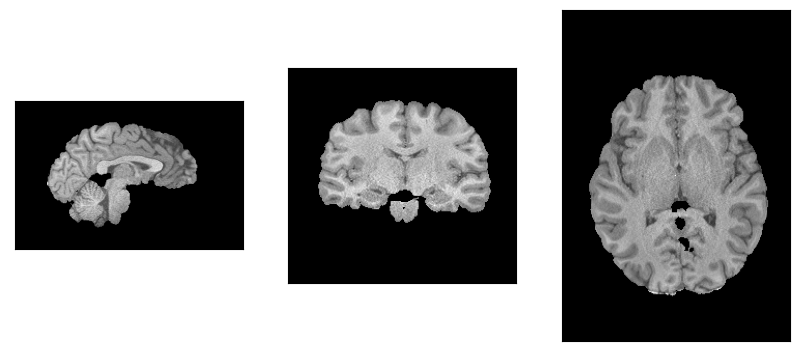

In [19]:
# We can check that the brain_arr looks good, by plotting individual slices like we would if it was any other numpy array
plt.figure(figsize=(10,5));
plt.subplot(1,3,1); plt.imshow(np.rot90(brain_arr[110,:,:]),cmap='gray') ;plt.xticks([]);plt.yticks([]);
plt.subplot(1,3,2); plt.imshow(np.rot90(brain_arr[:,160,:]),cmap='gray') ;plt.xticks([]);plt.yticks([]);
plt.subplot(1,3,3); plt.imshow(np.rot90(brain_arr[:,:,104]),cmap='gray') ;plt.xticks([]);plt.yticks([]);

This SLOW(ER) approach is useful because it allows for more control over the images. You might use this if you're doing more complex indexing or if you want to have acess to the values at the intermediate steps. 

(array([5.76600e+03, 8.23430e+04, 2.55921e+05, 8.22551e+05, 9.33102e+05,
        3.61258e+05, 8.15600e+03, 1.02000e+02, 2.10000e+01, 9.00000e+00]),
 array([ 19.170998,  38.686195,  58.201393,  77.71659 ,  97.23179 ,
        116.746994, 136.26219 , 155.77739 , 175.29259 , 194.80779 ,
        214.32298 ], dtype=float32),
 <BarContainer object of 10 artists>)

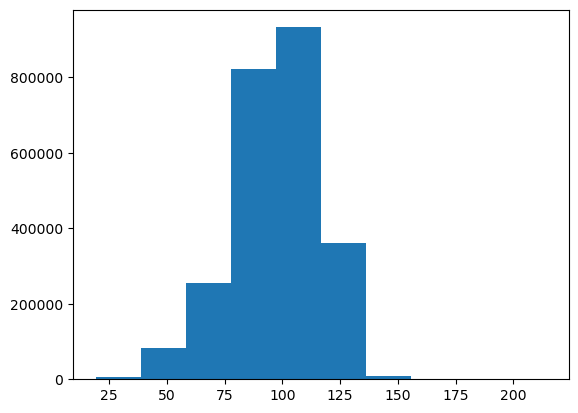

In [20]:
# For example now we can plot a histogram of the values at the brain locations
plt.hist(brain_values)

But now brain_arr is just a numpy arr, it does not have the metadata and header info like we had before. If we want to save this as a brain image (nifti file with .nii or .nii.gz extension) we'll need it.

We can do that easily by copying the remaining information from the anat object, using the .new_image_like function

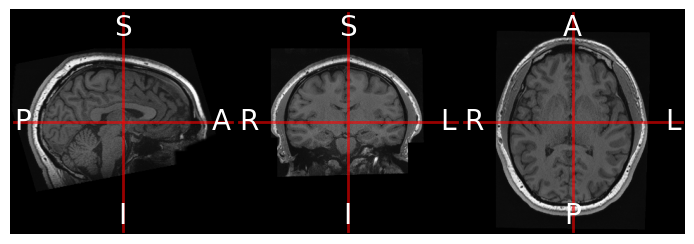

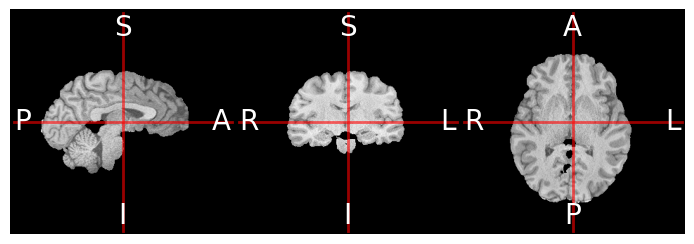

In [21]:
# .new_image_like method will use information stored in anat to create an image with the same metadata and header info, but differet values
anat.plot_ortho(flat=True)
brain_im = anat.new_image_like(brain_arr) # Creates a new image that's "like" anat, but with different values
brain_im.plot_ortho(flat=True) # Same results as the one from the fast approach

In [22]:
# .new_image_like is a great function to create valid brain images from numpy arrays. 
# Usually when analyzing data, you'll read in a brain image, and perform anayzed on just the numpy array values. 
# Then at the end you might have a map of t-values or correlation values or something else and you'll want to visualize it in "brain space"
# .new_image_like helps you do that
# To use .new_image_like the numpy array has to be the same shape and size as the brain images. 
# E.g. the anat we're using has a shape of (220, 320, 208) voxels. So the numpy array also has to have a shape of (220, 320, 208) otherwise it will error out

### Resampling

In [23]:
# Sometimes you might want to change the size of the image. Either to make all subject brains the same size, or to make them smaller for analyses (e.g. feeding them to a neural network)

In [24]:
# Currently our brain image is (220, 320, 208) voxels is size, with each voxel covering .8mm^3 portion of the brain. 
brain

ANTsImage (LPI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (220, 320, 208)
	 Spacing    : (0.8, 0.8, 0.8)
	 Origin     : (88.9204, 128.4992, -65.1701)
	 Direction  : [-1.  0.  0.  0. -1.  0.  0.  0.  1.]

In [25]:
# Let's make it smaller, say (64 64 64) voxels in size, with each voxel being correspondingly bigger

In [26]:
brain_tiny = ants.resample_image(image=brain, # image to resampe
    resample_params=(64,64,64), # The size you want 
    use_voxels=True, # True if you're specifying the size in voxels, False if in mm^3
    interp_type=1,# Interpolation: one of 0 (linear), 1 (nearest neighbor), 2 (gaussian), 3 (windowed sinc), 4 (bspline)
                   )
brain_tiny # Resulting image is the desired size: 64,64,64 with the voxel size automatically adjusted to (2.7, 4.05, 2.62) from (0.8, 0.8, 0.8)
# The metadata and header have also been adjusted to match the new size, so you can save this file as a valid brain image (.nii or .nii.gz)

ANTsImage (LPI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (64, 64, 64)
	 Spacing    : (2.781, 4.0508, 2.6286)
	 Origin     : (88.9204, 128.4992, -65.1701)
	 Direction  : [-1.  0.  0.  0. -1.  0.  0.  0.  1.]

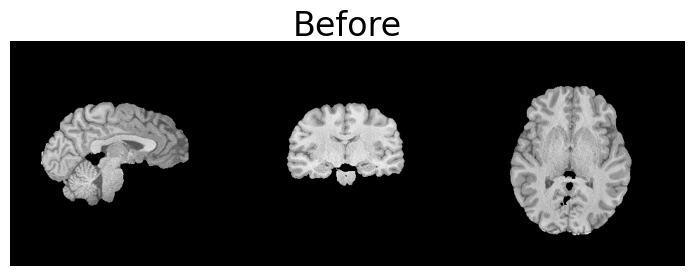

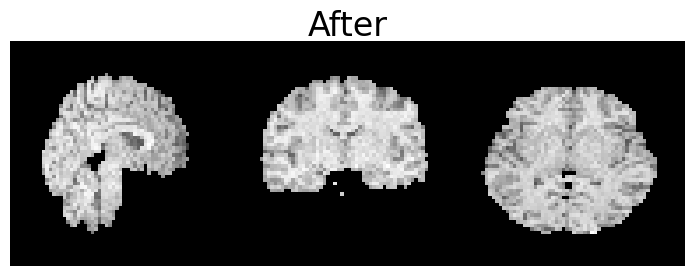

In [27]:
brain.plot_ortho(flat=True,title='Before',textfontcolor='k',xyz_lines=False,orient_labels=False)
brain_tiny.plot_ortho(flat=True,title='After',textfontcolor='k',xyz_lines=False,orient_labels=False)

### Saving files

In [28]:
# Saving brain files is easy, using the .to_filename method and specifying the path or filename for the new file with extension (.nii or .nii.gz)
brain_im.to_filename('./Data/sub-28702/anat/ExtractedBrain.nii.gz') 
brain_tiny.to_filename('./Data/sub-28702/anat/ExtractedBrainTiny.nii.gz') 
# ^ This saves a file that can be read back in with antspy or downloaded and viewed by one of many MRI sofware tools like:
# - MRIcron https://people.cas.sc.edu/rorden/mricron/install.html (personal favorite)
# - MANGO https://mangoviewer.com/
# -IMAGEJ https://imagej.net/ij/
# -SPM https://www.fil.ion.ucl.ac.uk/spm/software/spm12/ for MATLAB
# -FSL https://open.win.ox.ac.uk/pages/fsl/fsleyes/fsleyes/userdoc/install.html